In [38]:
%run IDM_helper_functions.ipynb

In [39]:
W_pos, W_neg = 52500, 8400
B1, B2 = 0, 0
N, theta = 2000, 51450

y1, y2 = 0.2, 0.2
beta=1/24
print(energy(y1,y2))
print(dEdy1(y1, y2, W_pos, W_neg, B1, theta))
print(dEdy2(y1,y2, W_pos, W_neg, B2, theta))
print(free_energy(y1,y2,N=2000))
print(dFdy1(y1,y2, W_pos, W_neg, B1, theta, beta, N))
print(dFdy2(y1,y2, W_pos, W_neg, B2, theta, beta, N))

16716.0
32130.0
32130.0
-7303.316329833018
-1141.064666877377
-1141.064666877377


In [51]:
# Training data  52500, W_neg = 8400
n_sim_train = 200
prior = utils.BoxUniform(low=[0,0.2,0.1,0.01,52000, 8200], high=[0.8,0.6,0.6,0.1,53000, 8600])
param = prior.sample((n_sim_train,))
x_IDM_train = simul_IDM_EM6(np.array(param))

param = param[x_IDM_train[:,1]!=100] ## remove trials longer than 3s
x_IDM_train = x_IDM_train[x_IDM_train[:,1]!=100] ## remove trials longer than 3s


sim0


In [52]:
from sbi.inference import MNLE
from sbi.utils import likelihood_nn



# build mnle net
neural_net = likelihood_nn(model="mnle",  num_transforms=2,  # number of transforms in the neural spline flow (the more the more expressive, but slower)
  num_bins = 5,  # number of bins for the splines (the more the more expressive, but slower)
  hidden_features = 100,  # number of hidden units for the Categorical net and the Spline Flow)
  hidden_layers = 2,  # number of hidden layers
  tail_bound = 10.0,  # upper and lower bound for neural splines
  log_transform_x = True,  # whether to log-transform the reaction times to make them unbounded.
                          )


In [53]:
# Train MNLE and obtain MCMC-based posterior.

trainer = MNLE(prior=prior, density_estimator=neural_net)
trainer = trainer.append_simulations(param, x_IDM_train)
mnle = trainer.train()
mnle

 Neural network successfully converged after 54 epochs.

MixedDensityEstimator(
  (discrete_net): CategoricalNet(
    (activation): Sigmoid()
    (softmax): Softmax(dim=1)
    (input_layer): Sequential(
      (0): Standardize()
      (1): Linear(in_features=6, out_features=100, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
    )
    (output_layer): Linear(in_features=100, out_features=2, bias=True)
  )
  (continuous_net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): AffineTransform()
        (1): PiecewiseRationalQuadraticCouplingTransform(
          (transform_net): ContextSplineMap(
            (spline_predictor): Sequential(
              (0): Linear(in_features=7, out_features=100, bias=True)
              (1): ReLU()
              (2): Linear(in_features=100, out_features=100, bias=True)
              (3): ReLU()
              (4): Linear(in_features=100, out_fea

In [ ]:
mcmc_parameters = dict(num_chains=10,thin=10,warmup_steps=100,init_strategy="sir")

In [28]:
# inference with different x_o that has 100 trials
#torch.manual_seed(41)
num_trials = 1000
num_samples = 300
parameters_o = prior_IDM.sample((1,))
x_o = simul_IDM_EM5_Exc(np.array(parameters_o.repeat(num_trials, 1)))

sim0


In [29]:
mnle_posterior = trainer.build_posterior(mnle, prior_IDM)
mnle_samples = mnle_posterior.sample((num_samples,), x=x_o)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3100 [00:00<?, ?it/s]


KeyboardInterrupt



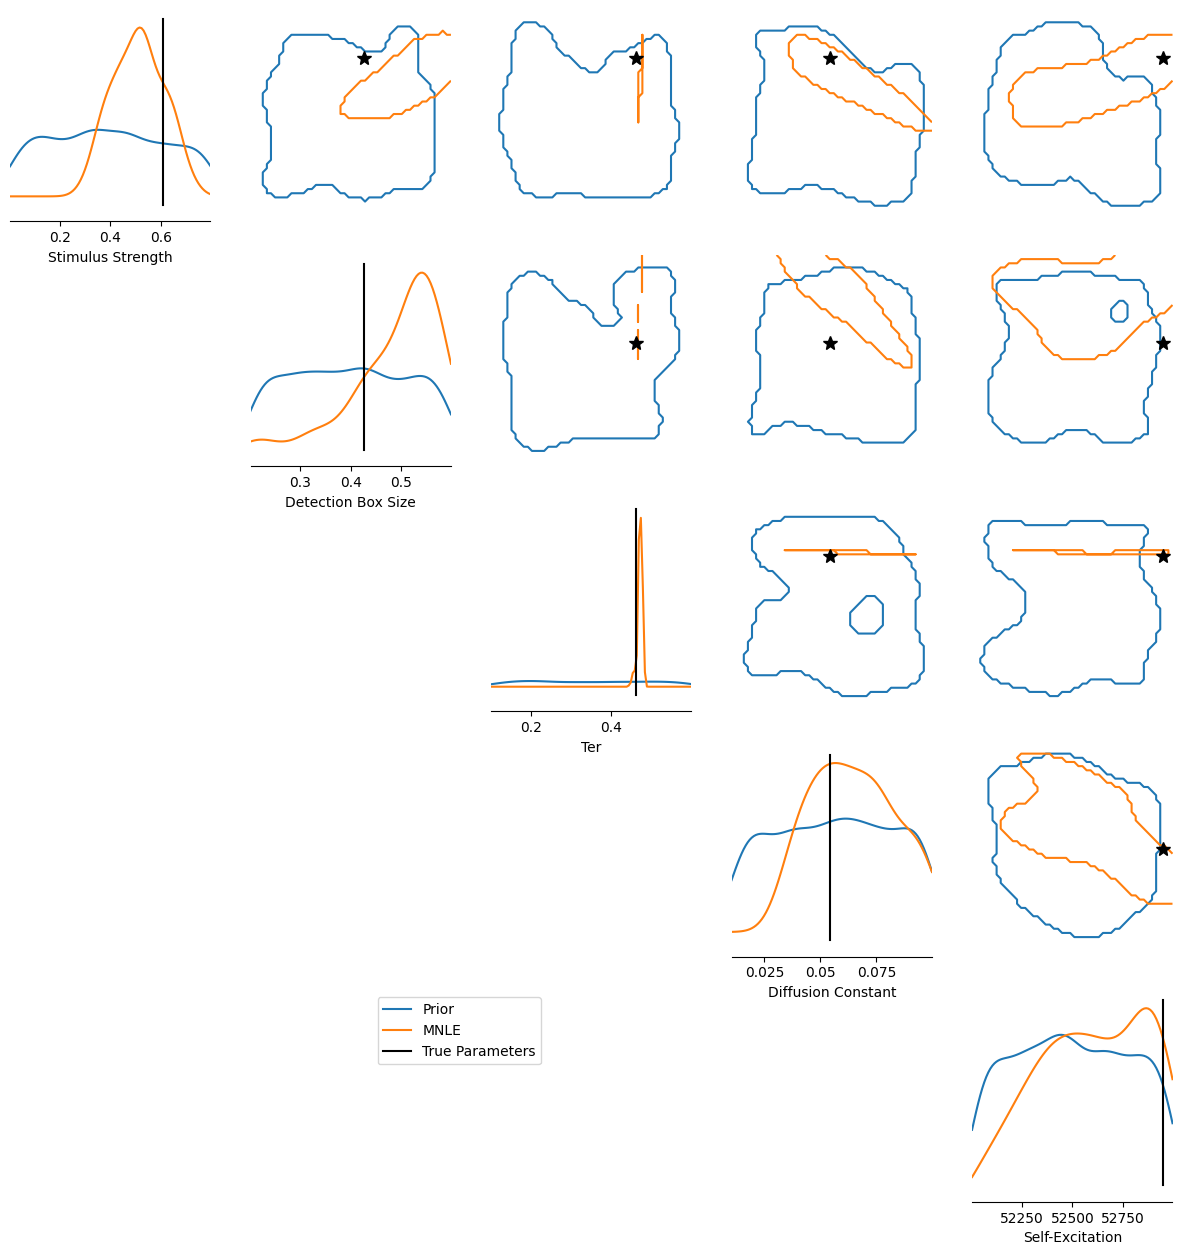

In [15]:
pair_plot(prior_IDM, mnle_samples, parameters_o, figsize = (15,15), contour = 0.7, 
          labels=['Stimulus Strength', 'Detection Box Size','Ter', 'Diffusion Constant',"Self-Excitation", "Mutual Inhibition"])

In [35]:
n_trials = 1000
sim_num = 20

param_IDM = prior_IDM.sample((sim_num,))
par_fitted = np.zeros((sim_num,param_IDM.shape[1]))

In [36]:
for i in range(sim_num):
    print(i)
    IDM_o = simul_IDM_EM6(np.tile(param_IDM[i,:], (n_trials,1))) # 

    mcmc_parameters = dict(num_chains=10,thin=10,warmup_steps=50,init_strategy="proposal")
    mnle_posterior = trainer.build_posterior(mcmc_method="slice_np_vectorized", 
                                             mcmc_parameters=mcmc_parameters, 
                                             prior = prior)

    mnle_posterior.set_default_x(IDM_o)
    mnle_map = mnle_posterior.map()

    par_fitted[i,:] = np.array(mnle_map)
    print(param_IDM[i,:])
    print(mnle_map)

0
sim0
Optimization was interrupted after 749 iterations. 
tensor([5.1588e-01, 4.9416e-01, 4.3457e-01, 9.7849e-02, 5.2232e+04, 8.3671e+03])
tensor([5.8433e-01, 5.6729e-01, 4.4353e-01, 8.2383e-02, 5.2089e+04, 8.2540e+03])
1
sim0


KeyboardInterrupt: 

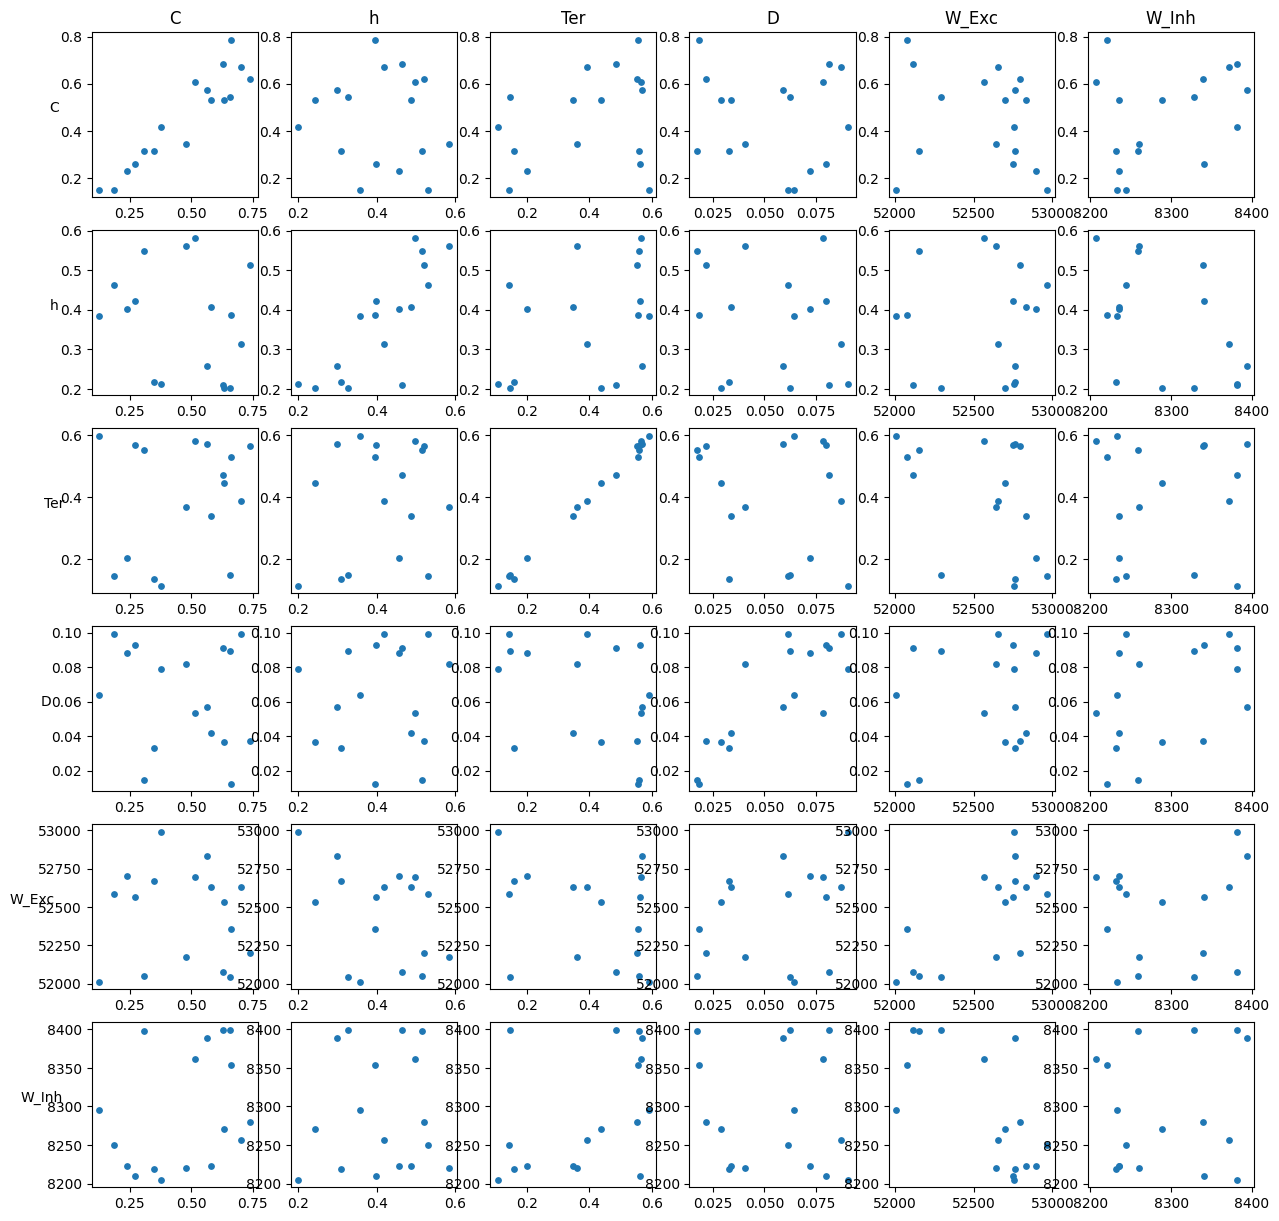

In [32]:
## n_trials = 1000
par_labels = ["C", "h", "Ter", "D","W_Exc", "W_Inh"]
par_fitted_labels = ["C", "h", "Ter", "D","W_Exc", "W_Inh"]
sim_fit_plot_all(param_IDM[0:17,:], par_fitted[0:17,:], par_labels, par_fitted_labels, s = 15, figsize=(15,15))